## Hacker Earth Challenge

### Predict Product Category from Invoice

Organizations around the world purchase goods & services from their suppliers via Purchase Order-Invoice exchange. Organizations raise Purchase Order for specific item and expected price. Suppliers then raise an Invoice to the organization for billing. As part of process streamlining, organizations catalogue items, i.e., they document all the item details in their procurement system. However in many cases organizations are required to purchase non-catalogued items.

**Task:** Attached is the data for analysis of expenditures based on Invoices received. You need to innovate a high accuracy classification system to predict ‘Product Category’, given invoice information.

In [1]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

Let's begin by importing the provided training data

In [2]:
train = pd.read_csv("Train.csv")

In [3]:
train.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,1,VENDOR-61,GL-6050100,6.973473,AETNA VARIABLE FUND - Apr-2002 - Store Managem...,CLASS-784
1,2,VENDOR-61,GL-6050100,25.053841,AETNA VARIABLE FUND - Nov-2000 - Store Managem...,CLASS-784
2,3,VENDOR-449,GL-6050100,53.573737,FAIRCHILD CORP - Nov-2001 - Store Management R...,CLASS-784
3,4,VENDOR-682,GL-6050100,67.388827,CALIFORNIA REAL ESTATE INVESTMENT TRUST - Aug-...,CLASS-784
4,5,VENDOR-682,GL-6050100,74.262047,CALIFORNIA REAL ESTATE INVESTMENT TRUST - Mar-...,CLASS-784


To get a deeper understanding of what the content of the *item_description* column is, let's look at a few examples

In [4]:
print(train['Item_Description'][1])
print(train['Item_Description'][200])
print(train['Item_Description'][300])
print(train['Item_Description'][4])
print(train['Item_Description'][5])


AETNA VARIABLE FUND - Nov-2000 - Store Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)
CANTEL INDUSTRIES INC - Oct-2010 - Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor
CHILE REPUBLIC OF - Feb-2011 - Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor
CALIFORNIA REAL ESTATE INVESTMENT TRUST - Mar-2013 - Store Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)
EDO CORP - Jul-2008 - Store Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)


On observing the item_description, we see that there is a pattern separated by a hyphen (Vendor Name - Date - Product Information)

On splitting the column into sub-columns to extract the relevant information:

In [5]:
train[['split1','split2','split3','split4','split5']] = train['Item_Description'].str.split(' - ', expand=True)

In [6]:
# We can go ahead and drop the Item description column now
train = train.drop('Item_Description', axis=1)

In [7]:
train.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Product_Category,split1,split2,split3,split4,split5
0,1,VENDOR-61,GL-6050100,6.973473,CLASS-784,AETNA VARIABLE FUND,Apr-2002,Store Management Real Estate Real Estate Servi...,None,None
1,2,VENDOR-61,GL-6050100,25.053841,CLASS-784,AETNA VARIABLE FUND,Nov-2000,Store Management Real Estate Real Estate Servi...,None,None
2,3,VENDOR-449,GL-6050100,53.573737,CLASS-784,FAIRCHILD CORP,Nov-2001,Store Management Real Estate Real Estate Servi...,None,None
3,4,VENDOR-682,GL-6050100,67.388827,CLASS-784,CALIFORNIA REAL ESTATE INVESTMENT TRUST,Aug-2006,Store Management Real Estate Real Estate Servi...,None,None
4,5,VENDOR-682,GL-6050100,74.262047,CLASS-784,CALIFORNIA REAL ESTATE INVESTMENT TRUST,Mar-2013,Store Management Real Estate Real Estate Servi...,None,None


In [8]:
train.isnull().sum()

Inv_Id                 0
Vendor_Code            0
GL_Code                0
Inv_Amt                0
Product_Category       0
split1                 0
split2                 0
split3                 0
split4              5421
split5              5706
dtype: int64

The product description part of the column has been split into 3 different columns, let's bring them all into one column

In [9]:
train ['desc'] = train['split3'].map(str) + train['split4'].map(str) + train['split5'].map(str)

In [10]:
train['desc'] = train['desc'].str.replace('None', '')

Now, let's look at what columns are we left with in the training dataset

In [11]:
train.columns

Index(['Inv_Id', 'Vendor_Code', 'GL_Code', 'Inv_Amt', 'Product_Category',
       'split1', 'split2', 'split3', 'split4', 'split5', 'desc'],
      dtype='object')

There are a number of columns that can be deemed as non-contributing to what we're trying to achieve. Since we want to classify invoices to their corresponding product category, the only columns that we're interested in are the product-related ones. Let's drop the unnecessary columns

In [12]:
train =train.drop(['Inv_Id', 'Vendor_Code', 'GL_Code','split1', 'split2', 'split3', 
                   'split4', 'split5' ], axis=1)

In [13]:
train.head()

,Inv_Amt,Product_Category,desc
0,6.973473,CLASS-784,Store Management Real Estate Real Estate Servi...
1,25.053841,CLASS-784,Store Management Real Estate Real Estate Servi...
2,53.573737,CLASS-784,Store Management Real Estate Real Estate Servi...
3,67.388827,CLASS-784,Store Management Real Estate Real Estate Servi...
4,74.262047,CLASS-784,Store Management Real Estate Real Estate Servi...


Let's see if we can extract any information from the product description column as it looks to be too large, and there would probably be a pattern within it

In [14]:
description_lu = pd.DataFrame(train['desc'].unique())

In [15]:
list(description_lu[0])

['Store Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)',
 'Corporate Services Human Resources Benefits Life and Health and Accident Insurance',
 'Store Construction Fixtures Store Fixtures Store Fixtures',
 'Supply Chain Logistics Transportation Services Freight Forwarders Services Other',
 'Non-Procurable Miscellaneous Non-Procurable Royalties Royalties',
 'Production Agency Fees & Commissions Other Agency',
 'Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor',
 'Non-Procurable Charity Organizations Charity Organizations Charity Organizations',
 'Supply Chain Logistics Transportation Services Parcel/Postage/Courier',
 'Corporate Services Human Resources Benefits Retirement and Pension Funds',
 'Information Technology Managed Services IT Managed Services IT Managed Services',
 "Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance",
 'Corporate Services Commercial

On observing the product descriptions, we can see that there seems to be a trend repeated across all the descriptions. We can further split the product descriptions into 4 sections<br>
In order to do this, let's first create a lookup for all the product descriptions and their corresponding splits

In [16]:
#Create a new Lookup Data Frame
lu_data = [['Store Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)', 
          'Store Management','Real Estate','Real Estate Services', 'Real Estate General'],
          ['Corporate Services Human Resources Benefits Life and Health and Accident Insurance','Corporate Services',
           'Human Resources','Benefits','Life and Health and Accident Insurance'],
          ['Store Construction Fixtures Store Fixtures Store Fixtures', 'Store Construction', 'Fixtures', 'Store Fixtures', 
           'Store Fixtures'],
          ['Supply Chain Logistics Transportation Services Freight Forwarders Services Other', 'Supply Chain Logistics', 
           'Transportation Services', 'Freight Forwarders Services', 'Other'],
          ['Non-Procurable Miscellaneous Non-Procurable Royalties Royalties','Non-Procurable', 'Miscellaneous', 
           'Non-Procurable Royalties', 'Royalties'],
          ['Production Agency Fees & Commissions Other Agency', 'Production Agency', 'Fees & Commissions', 'Other', 'Agency'],
          ['Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor', 'Corporate Services',
           'Human Resources', 'Contingent Labor/Temp Labor', 'Contingent Labor/Temp Labor'],
          ['Non-Procurable Charity Organizations Charity Organizations Charity Organizations', 'Non-Procurable', 'Charity Organizations',
           'Charity Organizations', 'Charity Organizations'],
          ['Supply Chain Logistics Transportation Services Parcel/Postage/Courier','Supply Chain Logistics',
           'Transportation Services', 'Parcel/Postage/Courier', 'Other'],
          ['Corporate Services Human Resources Benefits Retirement and Pension Funds','Corporate Services','Human Resources',
           'Benefits', 'Retirement and Pension Funds'],
          ['Information Technology Managed Services IT Managed Services IT Managed Services','Information Technology',
           'Managed Services', 'IT Managed Services', 'IT Managed Services'],
          ["Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance","Corporate Services",
           "Commercial Insurance", "Workmen's Insurance", "Workmen's Insurance"],
          ['Corporate Services Commercial Insurance Building and Property Insurance Building and Property Insurance',
           'Corporate Services', 'Commercial Insurance', 'Building and Property Insurance', 'Building and Property Insurance'],
          ['Corporate Services Consulting Finance Consulting Audit & Risk Consulting','Corporate Services', 'Consulting',
           'Finance Consulting', 'Audit & Risk Consulting'],
          ['Non-Procurable Taxes Taxes Taxes','Non-Procurable', 'Taxes', 'Taxes', 'Taxes'],
          ['National Advertising Media BuyTraditional Catalogue','National Advertising', 'Media Buy','Traditional', 'Catalogue'],
          ['Digital Paid Media Media Buy ','Digital','Paid Media', 'Media', 'Buy'],
          ['National Advertising Media BuyTraditional Magazines', 'National Advertising', 'Media Buy', 'Traditional', 'Magazines'],
          ['National Advertising Media BuyTraditional Newspaper','National Advertising', 'Media Buy','Traditional', 'Newspaper'],
          ['National Advertising Media BuyTraditional Outdoor/Out of Home','National Advertising', 'Media Buy','Traditional', 
           'Outdoor/Out of Home'],
          ['Events and Promotions Agency Fees & Commissions Public Relations Agency','Events and Promotions', 'Agency',
           'Fees & Commissions', 'Public Relations Agency'],
          ['National Advertising Media BuyTraditional Television','National Advertising', 'Media Buy','Traditional', 'Television'],
          ['Production Agency Fees & Commissions Search Agency','Production', 'Agency', 'Fees & Commissions','Search Agency'],
          ['Digital Paid Media Media BuySocial Paid SocialContent Production with Influencer', 'Digital Paid Media', 'Media Buy',
           'Social', 'Paid Social Content Production with Influencer'],
          ['Events and Promotions Trade Show Expenses Promotional Gift for Trade Show','Events and Promotions', 'Trade Show',
           'Expenses', 'Promotional Gift for Trade Show'],
          ['Events and Promotions Trade Show Expenses Talent, Artists & Models for Trade Show','Events and Promotions',
           'Trade Show', 'Expenses', 'Talent, Artists & Models for Trade Show'],
          ['Production Artworking/Typesetting Prototype and Comp Production/Packaging Design','Production', 'Artworking/Typesetting',
           'Prototype and Comp','Production/Packaging Design'],
          ['Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Fleet Repair and Maintenance',
           'Corporate Services', 'Other Corporate Services', 'Auto Leasing and Maintenance','Auto Fleet Repair and Maintenance'],
          ['Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Leasing',
           'Corporate Services', 'Other Corporate Services', 'Auto Leasing and Maintenance', 'Auto Leasing'],
          ['Travel and Entertainment Ground Transportation Miscellaneous Company Car (Field Only) Miscellaneous Company Car (Field Only)',
           'Travel and Entertainment', 'Ground Transportation',  'Miscellaneous Company Car', 'Miscellaneous Company Car'],
          ['Store Management Real Estate Lease/Rent Base Rent','Store Management', 'Real Estate', 'Lease/Rent', 'Base Rent'],
          ['Facility Management Real Estate Lease/Rent Base Rent','Facility Management', 'Real Estate', 'Lease/Rent', 'Base Rent'],
          ['Facility Management Real Estate Real Estate Services Real Estate General (Search, Appraisal, Realtor Commission)',
           'Facility Management', 'Real Estate', 'Real Estate Services', 'Real Estate General'],
          ['Store Construction General Contractor General Requirements Final Site Clean Up','Store Construction', 'General Contractor',
           'General Requirements', 'Final Site Clean Up'],
          ['Facility Construction General Contractor General Requirements Final Site Clean Up', 'Facility Construction',
           'General Contractor', 'General Requirements', 'Final Site Clean Up'],
          ['Printed Collateral Direct Mail Post Card/Mailer','Printed', 'Collateral', 'Direct Mail', 'Post Card/Mailer'],
          ['Production Digital/Social Digital Display', 'Production', 'Digital/Social', 'Digital', 'Display'],
          ['Printed Collateral Miscellaneous Printed Materials Miscellaneous Printed Materials', 'Printed', 'Collateral',
           'Miscellaneous Printed Materials', 'Miscellaneous Printed Materials']]
          
lu_df = pd.DataFrame(lu_data, columns = ['desc', 'Var1', 'Var2', 'Var3', 'Var4']) 

In [17]:
lu_df.head()

,desc,Var1,Var2,Var3,Var4
0,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General
1,Corporate Services Human Resources Benefits Li...,Corporate Services,Human Resources,Benefits,Life and Health and Accident Insurance
2,Store Construction Fixtures Store Fixtures Sto...,Store Construction,Fixtures,Store Fixtures,Store Fixtures
3,Supply Chain Logistics Transportation Services...,Supply Chain Logistics,Transportation Services,Freight Forwarders Services,Other
4,Non-Procurable Miscellaneous Non-Procurable Ro...,Non-Procurable,Miscellaneous,Non-Procurable Royalties,Royalties


Let's replace the description column in our training dataset with these 4 splits based on the lookup created

In [18]:
train_refined = pd.merge(train, lu_df, how='left',left_on='desc', right_on='desc' )

In [19]:
train_refined.head()

,Inv_Amt,Product_Category,desc,Var1,Var2,Var3,Var4
0,6.973473,CLASS-784,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General
1,25.053841,CLASS-784,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General
2,53.573737,CLASS-784,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General
3,67.388827,CLASS-784,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General
4,74.262047,CLASS-784,Store Management Real Estate Real Estate Servi...,Store Management,Real Estate,Real Estate Services,Real Estate General


In [20]:
train_refined = train_refined.drop(['desc'], axis=1 )

In [21]:
train_refined.head()

,Inv_Amt,Product_Category,Var1,Var2,Var3,Var4
0,6.973473,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
1,25.053841,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
2,53.573737,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
3,67.388827,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
4,74.262047,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General


Now we have our training data that is concise and we can proceed with further analysis 

Let's see if the price column varies based on the different product categories

In [22]:
train_refined['Product_Category'].value_counts()

CLASS-559     1521
CLASS-75       985
CLASS-323      773
CLASS-51       464
CLASS-177      370
CLASS-764      219
CLASS-50       196
CLASS-522      117
CLASS-629      115
CLASS-322      107
CLASS-942      107
CLASS-368       79
CLASS-720       73
CLASS-651       68
CLASS-913       53
CLASS-278       50
CLASS-671       42
CLASS-74        42
CLASS-804       38
CLASS-230       34
CLASS-1042      34
CLASS-110       29
CLASS-765       27
CLASS-95        27
CLASS-123       26
CLASS-571       22
CLASS-784       19
CLASS-453       15
CLASS-606       13
CLASS-839       13
CLASS-668       13
CLASS-953        8
CLASS-49         7
CLASS-489        4
CLASS-758        3
CLASS-783        2
CLASS-947        2
CLASS-816        2
Name: Product_Category, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x20c070f7470>,
 'caps': [<matplotlib.lines.Line2D at 0x20c070f7d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c070f7320>],
 'medians': [<matplotlib.lines.Line2D at 0x20c070fc5c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c070fc9e8>],
 'means': []}

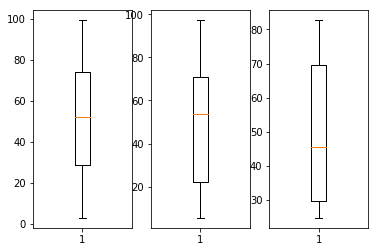

In [23]:
plt.subplot(1,3,1)
plt.boxplot(train_refined.loc[train_refined['Product_Category'] == 'CLASS-368', 'Inv_Amt'])

plt.subplot(1,3,2)
plt.boxplot(train_refined.loc[train_refined['Product_Category'] == 'CLASS-784', 'Inv_Amt'])

plt.subplot(1,3,3)
plt.boxplot(train_refined.loc[train_refined['Product_Category'] == 'CLASS-953', 'Inv_Amt'])


We can see that the price distribution across the products is not very distinguishable. There deosn't seem to be an evident patter between the differnt product categories and their prices

In [24]:
train_refined.head()

,Inv_Amt,Product_Category,Var1,Var2,Var3,Var4
0,6.973473,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
1,25.053841,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
2,53.573737,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
3,67.388827,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General
4,74.262047,CLASS-784,Store Management,Real Estate,Real Estate Services,Real Estate General


Encoding the categorical variables

In [25]:
var1_levels = pd.get_dummies(train_refined['Var1'])

In [26]:
var1_levels.columns

Index(['Corporate Services', 'Digital Paid Media', 'Events and Promotions',
       'Facility Construction', 'Facility Management',
       'Information Technology', 'National Advertising', 'Non-Procurable',
       'Printed', 'Production', 'Production Agency', 'Store Construction',
       'Store Management', 'Supply Chain Logistics',
       'Travel and Entertainment'],
      dtype='object')

In [27]:
var1_levels.columns = ['var1_CorporateServices', 'var1_DigitalPaidMedia', 'var1_EventsandPromotions','var1_FacilityConstruction', 
                       'var1_FacilityManagement', 'var1_InformationTechnology', 'var1_NationalAdvertising', 'var1_Non-Procurable',
                       'var1_Printed', 'var1_Production', 'var1_ProductionAgency', 'var1_StoreConstruction', 
                       'var1_StoreManagement', 'var1-SupplyChainLogistics', 'var1_TravelandEntertainment']

In [28]:
train_refined2 = pd.concat([train_refined, var1_levels], axis=1)

In [29]:
var2_levels = pd.get_dummies(train_refined['Var2'])

In [30]:
var2_levels.columns

Index(['Agency', 'Artworking/Typesetting', 'Charity Organizations',
       'Collateral', 'Commercial Insurance', 'Consulting', 'Digital/Social',
       'Fees & Commissions', 'Fixtures', 'General Contractor',
       'Ground Transportation', 'Human Resources', 'Managed Services',
       'Media Buy', 'Miscellaneous', 'Other Corporate Services', 'Real Estate',
       'Taxes', 'Trade Show', 'Transportation Services'],
      dtype='object')

In [31]:
var2_levels.columns = ['var2_Agency', 'var2_Artworking/Typesetting', 'var2_CharityOrganizations','var2_Collateral',
                       'var2_CommercialInsurance', 'var2_Consulting', 'var2_Digital/Social', 'var2_Fees&Commissions',
                       'var2_Fixtures', 'var2_GeneralContractor', 'var2_GroundTransportation', 'var2_HumanResources',
                       'var2_ManagedServices', 'var2_MediaBuy','var2_Miscellaneous', 'var2_OtherCorporateServices', 
                       'var2_RealEstate', 'var2_Taxes', 'var2_TradeShow', 'var2_TransportationServices']

In [32]:
train_refined2 = pd.concat([train_refined2, var2_levels], axis=1)

In [33]:
train_refined2.columns

Index(['Inv_Amt', 'Product_Category', 'Var1', 'Var2', 'Var3', 'Var4',
       'var1_CorporateServices', 'var1_DigitalPaidMedia',
       'var1_EventsandPromotions', 'var1_FacilityConstruction',
       'var1_FacilityManagement', 'var1_InformationTechnology',
       'var1_NationalAdvertising', 'var1_Non-Procurable', 'var1_Printed',
       'var1_Production', 'var1_ProductionAgency', 'var1_StoreConstruction',
       'var1_StoreManagement', 'var1-SupplyChainLogistics',
       'var1_TravelandEntertainment', 'var2_Agency',
       'var2_Artworking/Typesetting', 'var2_CharityOrganizations',
       'var2_Collateral', 'var2_CommercialInsurance', 'var2_Consulting',
       'var2_Digital/Social', 'var2_Fees&Commissions', 'var2_Fixtures',
       'var2_GeneralContractor', 'var2_GroundTransportation',
       'var2_HumanResources', 'var2_ManagedServices', 'var2_MediaBuy',
       'var2_Miscellaneous', 'var2_OtherCorporateServices', 'var2_RealEstate',
       'var2_Taxes', 'var2_TradeShow', 'var2_Transportat

In [34]:
var3_levels = pd.get_dummies(train_refined['Var3'])

In [35]:
var3_levels.columns

Index(['Auto Leasing and Maintenance', 'Benefits',
       'Building and Property Insurance', 'Charity Organizations',
       'Contingent Labor/Temp Labor', 'Digital', 'Direct Mail', 'Expenses',
       'Fees & Commissions', 'Finance Consulting',
       'Freight Forwarders Services', 'General Requirements',
       'IT Managed Services', 'Lease/Rent', 'Miscellaneous Company Car',
       'Miscellaneous Printed Materials', 'Non-Procurable Royalties', 'Other',
       'Parcel/Postage/Courier', 'Prototype and Comp', 'Real Estate Services',
       'Social', 'Store Fixtures', 'Taxes', 'Traditional',
       'Workmen's Insurance'],
      dtype='object')

In [36]:
var3_levels.columns = ['var3_AutoLeasingandMaintenance', 'var3_Benefits', 'var3_BuildingandPropertyInsurance',
                       'var3_CharityOrganizations', 
                       'var3_ContingentLabor/TempLabor', 'var3_Digital', 'var3_DirectMail', 'var3_Expenses', 
                       'var3_Fees&Commissions', 'var3_FinanceConsulting', 'var3_FreightForwardersServices', 
                       'var3_GeneralRequirements', 'var3_ITManagedServices', 'var3_Lease/Rent',  
                       'var3_MiscellaneousCompanyCar', 'var3_MiscellaneousPrintedMaterials', 'var3_Non-ProcurableRoyalties',
                       'var3_Other', 
                       'var3_Parcel/Postage/Courier', 'var3_PrototypeandComp', 'var3_RealEstateServices', 'var3_Social',
                       'var3_StoreFixtures','var3_Taxes','var3_Traditional',
                       "var3_Workmen'sInsurance"]

In [37]:
train_refined2 = pd.concat([train_refined2, var3_levels], axis=1)

In [38]:
train_refined2.columns

Index(['Inv_Amt', 'Product_Category', 'Var1', 'Var2', 'Var3', 'Var4',
       'var1_CorporateServices', 'var1_DigitalPaidMedia',
       'var1_EventsandPromotions', 'var1_FacilityConstruction',
       'var1_FacilityManagement', 'var1_InformationTechnology',
       'var1_NationalAdvertising', 'var1_Non-Procurable', 'var1_Printed',
       'var1_Production', 'var1_ProductionAgency', 'var1_StoreConstruction',
       'var1_StoreManagement', 'var1-SupplyChainLogistics',
       'var1_TravelandEntertainment', 'var2_Agency',
       'var2_Artworking/Typesetting', 'var2_CharityOrganizations',
       'var2_Collateral', 'var2_CommercialInsurance', 'var2_Consulting',
       'var2_Digital/Social', 'var2_Fees&Commissions', 'var2_Fixtures',
       'var2_GeneralContractor', 'var2_GroundTransportation',
       'var2_HumanResources', 'var2_ManagedServices', 'var2_MediaBuy',
       'var2_Miscellaneous', 'var2_OtherCorporateServices', 'var2_RealEstate',
       'var2_Taxes', 'var2_TradeShow', 'var2_Transportat

In [39]:
var4_levels = pd.get_dummies(train_refined['Var4'])

In [40]:
var4_levels.columns

Index(['Agency', 'Audit & Risk Consulting',
       'Auto Fleet Repair and Maintenance', 'Auto Leasing', 'Base Rent',
       'Building and Property Insurance', 'Catalogue', 'Charity Organizations',
       'Contingent Labor/Temp Labor', 'Display', 'Final Site Clean Up',
       'IT Managed Services', 'Life and Health and Accident Insurance',
       'Magazines', 'Miscellaneous Company Car',
       'Miscellaneous Printed Materials', 'Newspaper', 'Other',
       'Outdoor/Out of Home', 'Paid Social Content Production with Influencer',
       'Post Card/Mailer', 'Production/Packaging Design',
       'Promotional Gift for Trade Show', 'Public Relations Agency',
       'Real Estate General', 'Retirement and Pension Funds', 'Royalties',
       'Search Agency', 'Store Fixtures',
       'Talent, Artists & Models for Trade Show', 'Taxes', 'Television',
       'Workmen's Insurance'],
      dtype='object')

In [41]:
var4_levels.columns = ['var4_Agency', 'var4_Audit&RiskConsulting', 'var4_AutoFleetRepairandMaintenance', 'var4_AutoLeasing',
                       'var4_BaseRent', 'var4_BuildingandPropertyInsurance', 'var4_Catalogue', 'var4_CharityOrganizations',
                       'var4_ContingentLabor/TempLabor', 
                       'var4_Display', 'var4_FinalSiteCleanUp', 'var4_ITManagedServices', 
                       'var4_LifeandHealthandAccidentInsurance', 'var4_Magazines','var4_MiscellaneousCompanyCar', 
                       'var4_MiscellaneousPrintedMaterials', 'var4_Newspaper','var4_Other', 'var4_Outdoor/OutofHome',
                       'var4_PaidSocialContentProductionwithInfluencer','var4_PostCard/Mailer', 
                       'var4_Production/PackagingDesign', 'var4_PromotionalGiftforTradeShow', 'var4_PublicRelationsAgency', 
                       'var4_RealEstateGeneral', 'var4_RetirementandPensionFunds', 'var4_Royalties', 
                       'var4_SearchAgency', 'var4_StoreFixtures',
                       'var4_Talent,Artists&ModelsforTradeShow', 'var4_Taxes','var4_Television',"var4_Workmen'sInsurance"]

In [42]:
train_refined2 = pd.concat([train_refined2, var4_levels], axis=1)

In [43]:
train_refined2.columns

Index(['Inv_Amt', 'Product_Category', 'Var1', 'Var2', 'Var3', 'Var4',
       'var1_CorporateServices', 'var1_DigitalPaidMedia',
       'var1_EventsandPromotions', 'var1_FacilityConstruction',
       'var1_FacilityManagement', 'var1_InformationTechnology',
       'var1_NationalAdvertising', 'var1_Non-Procurable', 'var1_Printed',
       'var1_Production', 'var1_ProductionAgency', 'var1_StoreConstruction',
       'var1_StoreManagement', 'var1-SupplyChainLogistics',
       'var1_TravelandEntertainment', 'var2_Agency',
       'var2_Artworking/Typesetting', 'var2_CharityOrganizations',
       'var2_Collateral', 'var2_CommercialInsurance', 'var2_Consulting',
       'var2_Digital/Social', 'var2_Fees&Commissions', 'var2_Fixtures',
       'var2_GeneralContractor', 'var2_GroundTransportation',
       'var2_HumanResources', 'var2_ManagedServices', 'var2_MediaBuy',
       'var2_Miscellaneous', 'var2_OtherCorporateServices', 'var2_RealEstate',
       'var2_Taxes', 'var2_TradeShow', 'var2_Transportat

In [44]:
# Drop the original columns
train_refined2 = train_refined2.drop(['Var1', 'Var2', 'Var3', 'Var4'], axis=1)

In [45]:
train_refined2.head()

,Inv_Amt,Product_Category,var1_CorporateServices,var1_DigitalPaidMedia,var1_EventsandPromotions,var1_FacilityConstruction,var1_FacilityManagement,var1_InformationTechnology,var1_NationalAdvertising,var1_Non-Procurable,...,var4_PublicRelationsAgency,var4_RealEstateGeneral,var4_RetirementandPensionFunds,var4_Royalties,var4_SearchAgency,var4_StoreFixtures,"var4_Talent,Artists&ModelsforTradeShow",var4_Taxes,var4_Television,var4_Workmen'sInsurance
0,6.973473,CLASS-784,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,25.053841,CLASS-784,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,53.573737,CLASS-784,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,67.388827,CLASS-784,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,74.262047,CLASS-784,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now that we've handled all our categorical variables, let's proceed with the modelling bit

Our dependent variable is a multi-class variable. The classes are in string format and need to be encoded in a manner in which our algorithm can treat them as dependent variables

In [46]:
#Creating dependent variable class
factor = pd.factorize(train_refined2['Product_Category'])
train_refined2['Product_Category'] = factor[0]
definitions = factor[1]

In [47]:
train_refined2.head()

,Inv_Amt,Product_Category,var1_CorporateServices,var1_DigitalPaidMedia,var1_EventsandPromotions,var1_FacilityConstruction,var1_FacilityManagement,var1_InformationTechnology,var1_NationalAdvertising,var1_Non-Procurable,...,var4_PublicRelationsAgency,var4_RealEstateGeneral,var4_RetirementandPensionFunds,var4_Royalties,var4_SearchAgency,var4_StoreFixtures,"var4_Talent,Artists&ModelsforTradeShow",var4_Taxes,var4_Television,var4_Workmen'sInsurance
0,6.973473,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,25.053841,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,53.573737,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,67.388827,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,74.262047,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
factor[1]

Index(['CLASS-784', 'CLASS-489', 'CLASS-913', 'CLASS-368', 'CLASS-816',
       'CLASS-629', 'CLASS-177', 'CLASS-123', 'CLASS-671', 'CLASS-804',
       'CLASS-453', 'CLASS-1042', 'CLASS-95', 'CLASS-49', 'CLASS-947',
       'CLASS-110', 'CLASS-278', 'CLASS-522', 'CLASS-606', 'CLASS-651',
       'CLASS-765', 'CLASS-953', 'CLASS-839', 'CLASS-668', 'CLASS-758',
       'CLASS-942', 'CLASS-764', 'CLASS-50', 'CLASS-51', 'CLASS-559',
       'CLASS-75', 'CLASS-74', 'CLASS-783', 'CLASS-323', 'CLASS-322',
       'CLASS-720', 'CLASS-230', 'CLASS-571'],
      dtype='object')

In [49]:
#splitting the data into test and train
train_refined2.columns

Index(['Inv_Amt', 'Product_Category', 'var1_CorporateServices',
       'var1_DigitalPaidMedia', 'var1_EventsandPromotions',
       'var1_FacilityConstruction', 'var1_FacilityManagement',
       'var1_InformationTechnology', 'var1_NationalAdvertising',
       'var1_Non-Procurable', 'var1_Printed', 'var1_Production',
       'var1_ProductionAgency', 'var1_StoreConstruction',
       'var1_StoreManagement', 'var1-SupplyChainLogistics',
       'var1_TravelandEntertainment', 'var2_Agency',
       'var2_Artworking/Typesetting', 'var2_CharityOrganizations',
       'var2_Collateral', 'var2_CommercialInsurance', 'var2_Consulting',
       'var2_Digital/Social', 'var2_Fees&Commissions', 'var2_Fixtures',
       'var2_GeneralContractor', 'var2_GroundTransportation',
       'var2_HumanResources', 'var2_ManagedServices', 'var2_MediaBuy',
       'var2_Miscellaneous', 'var2_OtherCorporateServices', 'var2_RealEstate',
       'var2_Taxes', 'var2_TradeShow', 'var2_TransportationServices',
       'var3_AutoL

In [50]:
X = train_refined2.drop('Product_Category', axis=1)
y = train_refined2['Product_Category']

Splitting the data into test and train

In [51]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

Let's use the **Random Forest Classification** learnig algorithm to create our final multi-class model 

In [52]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Predicting the output on our test set using the model created

In [53]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [54]:
y_pred

array([ 3,  6, 30, ..., 29,  5, 29], dtype=int64)

In [55]:
reversefactor = dict(zip(range(38),definitions))

In [56]:
y_pred = np.vectorize(reversefactor.get)(y_pred)

In [57]:
y_test = np.vectorize(reversefactor.get)(y_test)

In [58]:
pred_test = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_pred)], axis=1)

In [59]:
pred_test.columns = ['y_test', 'y_pred']

In [60]:
pred_test.head()

,y_test,y_pred
0,CLASS-368,CLASS-368
1,CLASS-177,CLASS-177
2,CLASS-75,CLASS-75
3,CLASS-764,CLASS-764
4,CLASS-177,CLASS-177


Let's check the accuracy of our model

In [61]:
pred_test['accuracy'] = pred_test['y_test']==pred_test['y_pred']

In [62]:
pred_test['accuracy'].value_counts()[1]/pred_test['accuracy'].count()

0.9993006993006993

#### Making the Predictions on the Test Data given

Importing the testing data

In [63]:
test = pd.read_csv('Test.csv')

In [64]:
test.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description
0,6,VENDOR-1197,GL-6050100,10.916343,DESOTO INC - Jul-2008 - Store Management Real ...
1,12,VENDOR-792,GL-6050100,38.658772,CENTURY REALTY TRUST - Nov-2019 - Store Manage...
2,14,VENDOR-792,GL-6050100,46.780476,CENTURY REALTY TRUST - Jan-2006 - Store Manage...
3,18,VENDOR-792,GL-6050100,7.058866,CENTURY REALTY TRUST - Sep-2002 - Store Manage...
4,19,VENDOR-792,GL-6050100,32.931765,CENTURY REALTY TRUST - Nov-2018 - Store Manage...


Let's replicate all the data transformations that were done to the training data on the test data

In [65]:
test[['split1','split2','split3','split4','split5']] = test['Item_Description'].str.split(' - ', expand=True)
test = test.drop('Item_Description', axis=1)
test ['desc'] = test['split3'].map(str) + test['split4'].map(str) + test['split5'].map(str)
test['desc'] = test['desc'].str.replace('None', '')
test2 = test.drop(['Inv_Id', 'Vendor_Code', 'GL_Code', 'split1', 'split2', 'split3', 
                   'split4', 'split5' ], axis=1)
test_refined = pd.merge(test2, lu_df, how='left',left_on='desc', right_on='desc' )
test_refined = test_refined.drop(['desc'], axis=1 )

In [66]:
test_refined.head()

,Inv_Amt,Var1,Var2,Var3,Var4
0,10.916343,Store Management,Real Estate,Real Estate Services,Real Estate General
1,38.658772,Store Management,Real Estate,Real Estate Services,Real Estate General
2,46.780476,Store Management,Real Estate,Real Estate Services,Real Estate General
3,7.058866,Store Management,Real Estate,Real Estate Services,Real Estate General
4,32.931765,Store Management,Real Estate,Real Estate Services,Real Estate General


In [67]:
test_refined.shape

(2292, 5)

Encoding the categorical variables

In [68]:
var1_levels_test = pd.get_dummies(test_refined['Var1'])

In [69]:
var1_levels_test.columns

Index(['Corporate Services', 'Digital Paid Media', 'Events and Promotions',
       'Facility Construction', 'Facility Management',
       'Information Technology', 'National Advertising', 'Non-Procurable',
       'Printed', 'Production', 'Production Agency', 'Store Construction',
       'Store Management', 'Supply Chain Logistics',
       'Travel and Entertainment'],
      dtype='object')

In [70]:
var1_levels_test.columns = ['var1_CorporateServices', 'var1_DigitalPaidMedia', 'var1_EventsandPromotions',
                            'var1_FacilityConstruction', 
                       'var1_FacilityManagement', 'var1_InformationTechnology', 'var1_NationalAdvertising', 'var1_Non-Procurable',
                       'var1_Printed', 'var1_Production', 'var1_ProductionAgency', 'var1_StoreConstruction', 
                       'var1_StoreManagement', 'var1-SupplyChainLogistics', 'var1_TravelandEntertainment']

In [71]:
var2_levels_test = pd.get_dummies(test_refined['Var2'])

In [72]:
var2_levels_test.columns

Index(['Agency', 'Artworking/Typesetting', 'Charity Organizations',
       'Collateral', 'Commercial Insurance', 'Consulting', 'Digital/Social',
       'Fees & Commissions', 'Fixtures', 'General Contractor',
       'Ground Transportation', 'Human Resources', 'Managed Services',
       'Media Buy', 'Miscellaneous', 'Other Corporate Services', 'Real Estate',
       'Taxes', 'Trade Show', 'Transportation Services'],
      dtype='object')

In [73]:
var2_levels_test.columns = ['var2_Agency', 'var2_Artworking/Typesetting', 'var2_CharityOrganizations','var2_Collateral',
                       'var2_CommercialInsurance', 'var2_Consulting', 'var2_Digital/Social', 'var2_Fees&Commissions',
                       'var2_Fixtures', 'var2_GeneralContractor', 'var2_GroundTransportation', 'var2_HumanResources',
                       'var2_ManagedServices', 'var2_MediaBuy','var2_Miscellaneous', 'var2_OtherCorporateServices', 
                       'var2_RealEstate', 'var2_Taxes', 'var2_TradeShow', 'var2_TransportationServices']

In [74]:
var3_levels_test = pd.get_dummies(test_refined['Var3'])

In [75]:
var3_levels_test.columns

Index(['Auto Leasing and Maintenance', 'Benefits',
       'Building and Property Insurance', 'Charity Organizations',
       'Contingent Labor/Temp Labor', 'Digital', 'Direct Mail', 'Expenses',
       'Fees & Commissions', 'Finance Consulting',
       'Freight Forwarders Services', 'General Requirements',
       'IT Managed Services', 'Lease/Rent', 'Miscellaneous Company Car',
       'Miscellaneous Printed Materials', 'Non-Procurable Royalties', 'Other',
       'Parcel/Postage/Courier', 'Prototype and Comp', 'Real Estate Services',
       'Social', 'Store Fixtures', 'Taxes', 'Traditional',
       'Workmen's Insurance'],
      dtype='object')

In [76]:
var3_levels_test.columns = ['var3_AutoLeasingandMaintenance', 'var3_Benefits', 'var3_BuildingandPropertyInsurance',
                       'var3_CharityOrganizations', 
                       'var3_ContingentLabor/TempLabor', 'var3_Digital', 'var3_DirectMail', 'var3_Expenses', 
                       'var3_Fees&Commissions', 'var3_FinanceConsulting', 'var3_FreightForwardersServices', 
                       'var3_GeneralRequirements', 'var3_ITManagedServices', 'var3_Lease/Rent',  
                       'var3_MiscellaneousCompanyCar', 'var3_MiscellaneousPrintedMaterials', 'var3_Non-ProcurableRoyalties',
                       'var3_Other', 
                       'var3_Parcel/Postage/Courier', 'var3_PrototypeandComp', 'var3_RealEstateServices', 'var3_Social',
                       'var3_StoreFixtures','var3_Taxes','var3_Traditional',
                       "var3_Workmen'sInsurance"]

In [77]:
var4_levels_test = pd.get_dummies(test_refined['Var4'])

In [78]:
var4_levels_test.columns

Index(['Agency', 'Audit & Risk Consulting',
       'Auto Fleet Repair and Maintenance', 'Auto Leasing', 'Base Rent',
       'Building and Property Insurance', 'Catalogue', 'Charity Organizations',
       'Contingent Labor/Temp Labor', 'Display', 'Final Site Clean Up',
       'IT Managed Services', 'Life and Health and Accident Insurance',
       'Magazines', 'Miscellaneous Company Car',
       'Miscellaneous Printed Materials', 'Newspaper', 'Other',
       'Outdoor/Out of Home', 'Paid Social Content Production with Influencer',
       'Post Card/Mailer', 'Production/Packaging Design',
       'Promotional Gift for Trade Show', 'Public Relations Agency',
       'Real Estate General', 'Retirement and Pension Funds', 'Royalties',
       'Search Agency', 'Store Fixtures',
       'Talent, Artists & Models for Trade Show', 'Taxes', 'Television',
       'Workmen's Insurance'],
      dtype='object')

In [79]:
var4_levels_test.columns = ['var4_Agency', 'var4_Audit&RiskConsulting', 'var4_AutoFleetRepairandMaintenance', 'var4_AutoLeasing',
                       'var4_BaseRent', 'var4_BuildingandPropertyInsurance', 'var4_Catalogue', 'var4_CharityOrganizations',
                       'var4_ContingentLabor/TempLabor', 
                       'var4_Display', 'var4_FinalSiteCleanUp', 'var4_ITManagedServices', 
                       'var4_LifeandHealthandAccidentInsurance', 'var4_Magazines','var4_MiscellaneousCompanyCar', 
                       'var4_MiscellaneousPrintedMaterials', 'var4_Newspaper','var4_Other', 'var4_Outdoor/OutofHome',
                       'var4_PaidSocialContentProductionwithInfluencer','var4_PostCard/Mailer', 
                       'var4_Production/PackagingDesign', 'var4_PromotionalGiftforTradeShow', 'var4_PublicRelationsAgency', 
                       'var4_RealEstateGeneral', 'var4_RetirementandPensionFunds', 'var4_Royalties', 
                       'var4_SearchAgency', 'var4_StoreFixtures',
                       'var4_Talent,Artists&ModelsforTradeShow', 'var4_Taxes','var4_Television',"var4_Workmen'sInsurance"]

In [80]:
test_refined2 = pd.concat([test_refined, var1_levels_test, var2_levels_test, var3_levels_test, var4_levels_test], axis=1)

In [81]:
# Drop the original columns
test_refined2 = test_refined2.drop(['Var1', 'Var2', 'Var3', 'Var4'], axis=1)

In [82]:
X_pred = test_refined2[train_refined2.columns[train_refined2.columns!='Product_Category']]

In [83]:
X_pred.head()

,Inv_Amt,var1_CorporateServices,var1_DigitalPaidMedia,var1_EventsandPromotions,var1_FacilityConstruction,var1_FacilityManagement,var1_InformationTechnology,var1_NationalAdvertising,var1_Non-Procurable,var1_Printed,...,var4_PublicRelationsAgency,var4_RealEstateGeneral,var4_RetirementandPensionFunds,var4_Royalties,var4_SearchAgency,var4_StoreFixtures,"var4_Talent,Artists&ModelsforTradeShow",var4_Taxes,var4_Television,var4_Workmen'sInsurance
0,10.916343,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,38.658772,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,46.780476,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7.058866,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,32.931765,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now that we have the testing data in the same format as what our training data was, let's go ahead and run the model created on the test data

In [84]:
# Predicting the Test set results
y_pred = classifier.predict(X_pred)

In [85]:
y_pred

array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)

In [86]:
y_pred = np.vectorize(reversefactor.get)(y_pred)

Producing the final output submission file in the required format

In [87]:
final_output = pd.concat([test[['Inv_Id']], pd.DataFrame(y_pred)], axis=1)

In [88]:
final_output.columns = ['Inv_Id', 'Product_Category']

In [89]:
final_output.to_csv('final_prediction.csv', index=False)